In [1]:
# Load the cleaned training and test sets
import gensim
# Read in and clean data
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string

stopwords = nltk.corpus.stopwords.words('english')

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages['label'] = np.where(messages['label']=='spam', 1, 0)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [2]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(messages['clean_text'],
                                                    messages['label'], test_size=0.2)

In [5]:
X_train

374     [thanks, ringtone, order, reference, t91, char...
2242    [nope, wif, sis, lor, aft, bathing, dog, bathe...
490     [sorry, man, accounts, dry, would, want, could...
2013    [great, news, call, freefone, 08006344447, cla...
2610                   [usualiam, fine, happy, amp, well]
                              ...                        
5004    [guess, pub, im, im, happy, pig, clover, whate...
4110    [urgent, mobile, number, awarded, ukp2000, pri...
3468          [day, working, dayexcept, saturday, sunday]
3398    [yeah, wouldnt, leave, hour, least, hows, 4, s...
215     [finally, match, heading, towards, draw, predi...
Name: clean_text, Length: 4457, dtype: object

In [3]:
### Create Word2Vec
# Train a basic word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [6]:
# Replace words in each message with the learned word vector
words = set(w2v_model.wv.index2word)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

In [7]:
X_train_vect

array([array([[ 0.00109572, -0.24281509,  0.18762527, ...,  0.2105299 ,
        -0.12025137,  0.08955635],
       [-0.00232224, -0.13176213,  0.10675723, ...,  0.11264799,
        -0.06415091,  0.04747665],
       [-0.00450358, -0.10421721,  0.08167674, ...,  0.08953469,
        -0.05170779,  0.04130694],
       ...,
       [-0.00127336, -0.08906377,  0.06371441, ...,  0.07507122,
        -0.04405022,  0.02822443],
       [ 0.00429754, -0.22130236,  0.17800988, ...,  0.20008293,
        -0.11115149,  0.08235357],
       [-0.00485567, -0.05735053,  0.04473461, ...,  0.04357405,
        -0.02186082,  0.0160445 ]], dtype=float32),
       array([[ 0.00128968, -0.03554162,  0.02475207, ...,  0.03165592,
        -0.01411533,  0.01581873],
       [-0.00259658, -0.11198658,  0.09311064, ...,  0.09282094,
        -0.05588019,  0.03972748],
       [ 0.00165538, -0.05711161,  0.04659308, ...,  0.05544854,
        -0.02780095,  0.02332014],
       ...,
       [ 0.003691  , -0.6323218 ,  0.5017775 

In [8]:
# Average word vectors for each sentence (and assign a vector of zeros if the model
# did not learn any of the words in the text message during training
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [9]:
### Fit RandomForestClassifier On Word Vectors
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [10]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [13]:
# Evaluate predictions on test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 1.0 / Recall: 0.466 / Accuracy: 0.93


In [14]:
### Recall is very bad, now we will use RNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [18]:
# Import the tools needed and use our previously defined functions to calculate precision and recall
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [21]:
# Construct our basic RNN model framework
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          266208    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 276,673
Trainable params: 276,673
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [23]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 46ms/step - loss: 0.2723 - accuracy: 0.9136 - precision_m: 0.5029 - recall_m: 0.4050 - val_loss: 0.0920 - val_accuracy: 0.9767 - val_precision_m: 0.9286 - val_recall_m: 0.8064
Epoch 2/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0309 - accuracy: 0.9899 - precision_m: 0.9540 - recall_m: 0.9337 - val_loss: 0.0775 - val_accuracy: 0.9821 - val_precision_m: 0.9714 - val_recall_m: 0.8490
Epoch 3/10
140/140 [==============================] - 6s 46ms/step - loss: 0.0078 - accuracy: 0.9982 - precision_m: 0.9690 - recall_m: 0.9596 - val_loss: 0.1192 - val_accuracy: 0.9785 - val_precision_m: 0.9143 - val_recall_m: 0.7985
Epoch 4/10
140/140 [==============================] - 6s 45ms/step - loss: 0.0036 - accuracy: 0.9993 - precision_m: 0.9929 - recall_m: 0.9892 - val_loss: 0.1141 - val_accuracy: 0.9812 - val_precision_m: 0.9429 - val_recall_m: 0.8423
Epoch 5/10
140/140 [==============================] - 7s 47ms/step -

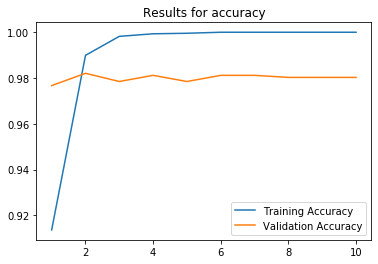

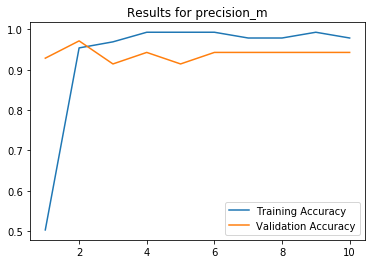

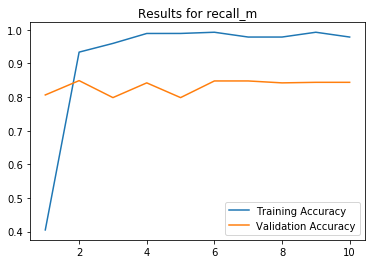

In [24]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()